In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid")

IMPORT DATA and conduct initial exploratory analysis

In [4]:
# Load data
train = pd.read_csv('../data/raw/train.csv', parse_dates=['date'])
test = pd.read_csv('../data/raw/test.csv')
sample_submission =pd.read_csv('../data/raw/sample_submission.csv')

# Preview
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (913000, 4)
Test shape: (45000, 4)


In [6]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [10]:
train.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


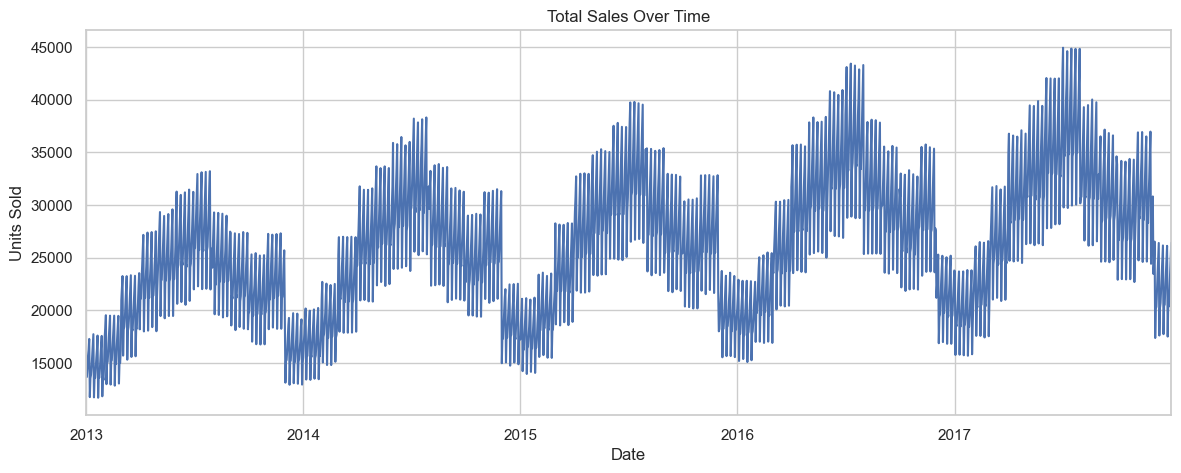

In [12]:
#Plot total demand over time
train.groupby('date')['sales'].sum().plot(figsize=(14, 5), title='Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

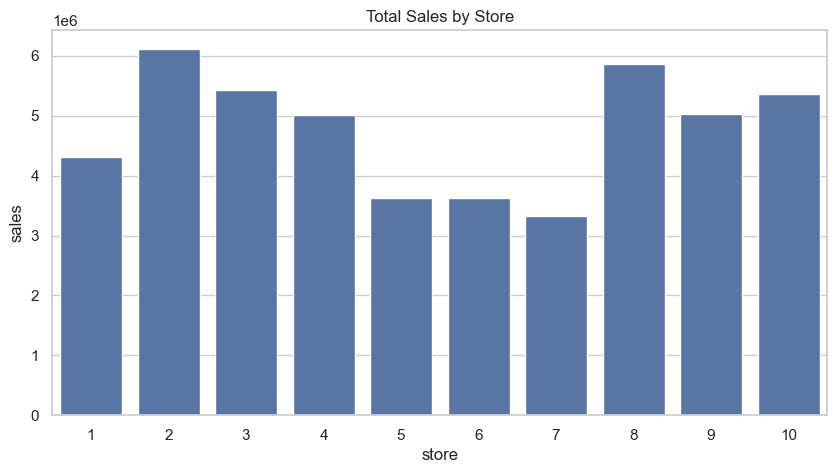

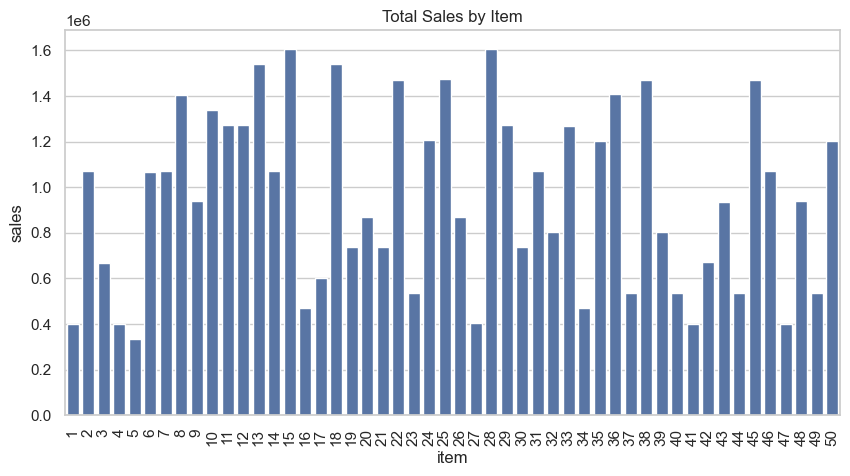

In [14]:
#Plot sales by store and item
plt.figure(figsize=(10, 5))
sns.barplot(data=train.groupby('store')['sales'].sum().reset_index(), x='store', y='sales')
plt.title('Total Sales by Store')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=train.groupby('item')['sales'].sum().reset_index().sort_values('sales', ascending=False), x='item', y='sales')
plt.title('Total Sales by Item')
plt.xticks(rotation=90)
plt.show()

In [16]:
#Feature engineering
# Sort values to ensure correct lag calculation
train = train.sort_values(by=['store', 'item', 'date'])

# Create lag features
train['lag_1'] = train.groupby(['store', 'item'])['sales'].shift(1)
train['lag_7'] = train.groupby(['store', 'item'])['sales'].shift(7)
train['lag_14'] = train.groupby(['store', 'item'])['sales'].shift(14)
train['lag_28'] = train.groupby(['store', 'item'])['sales'].shift(28)

# Create rolling statistics features (using shifted sales to avoid data leakage)
train['rolling_mean_7'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(window=7).mean()
train['rolling_mean_14'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(window=14).mean()
train['rolling_mean_30'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(window=30).mean()
train['rolling_std_7'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(window=7).std()

# Add date/time features
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['is_weekend'] = train['day_of_week'].isin([5, 6]).astype(int)

# Drop rows with NaN values (due to shifting/rolling)
train = train.dropna().reset_index(drop=True)

# Preview to confirm
print("Feature engineering complete. Sample:")
train.head()

Feature engineering complete. Sample:


,date,store,item,sales,lag_1,lag_7,lag_14,lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,day_of_week,month,year,is_weekend
0,2013-01-31,1,1,13,9.0,8.0,16.0,14.0,10.285714,10.857143,10.500000,2.751623,3,1,2013,0
1,2013-02-01,1,1,11,13.0,14.0,7.0,13.0,11.000000,10.642857,10.500000,2.708013,4,2,2013,0
2,2013-02-02,1,1,21,11.0,12.0,18.0,10.0,10.571429,10.928571,10.500000,2.370453,5,2,2013,1
3,2013-02-03,1,1,15,21.0,12.0,15.0,12.0,11.857143,11.142857,10.733333,4.634241,6,2,2013,1
4,2013-02-04,1,1,14,15.0,11.0,8.0,10.0,12.285714,11.142857,10.800000,4.785892,0,2,2013,0


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define features and target
feature_cols = [
    'lag_1', 'lag_7', 'lag_14', 'lag_28',
    'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_30', 'rolling_std_7',
    'day_of_week', 'month', 'year', 'is_weekend'
]

X = train[feature_cols]
y = train['sales']

# Time-based train/validation split: last 30 days = validation
cutoff_date = train['date'].max() - pd.Timedelta(days=30)
X_train = X[train['date'] <= cutoff_date]
y_train = y[train['date'] <= cutoff_date]
X_val = X[train['date'] > cutoff_date]
y_val = y[train['date'] > cutoff_date]

In [20]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_val)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)

In [21]:
# Define evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Results:")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R²:", r2_score(y_true, y_pred))

# 6. Evaluate both models
evaluate_model("Linear Regression", y_val, lr_preds)
evaluate_model("Random Forest", y_val, rf_preds)


Linear Regression Results:
RMSE: 9.436001103726026
MAE: 7.081191017331754
R²: 0.826132119991852

Random Forest Results:
RMSE: 7.944005102801316
MAE: 6.072158
R²: 0.8767683051207927


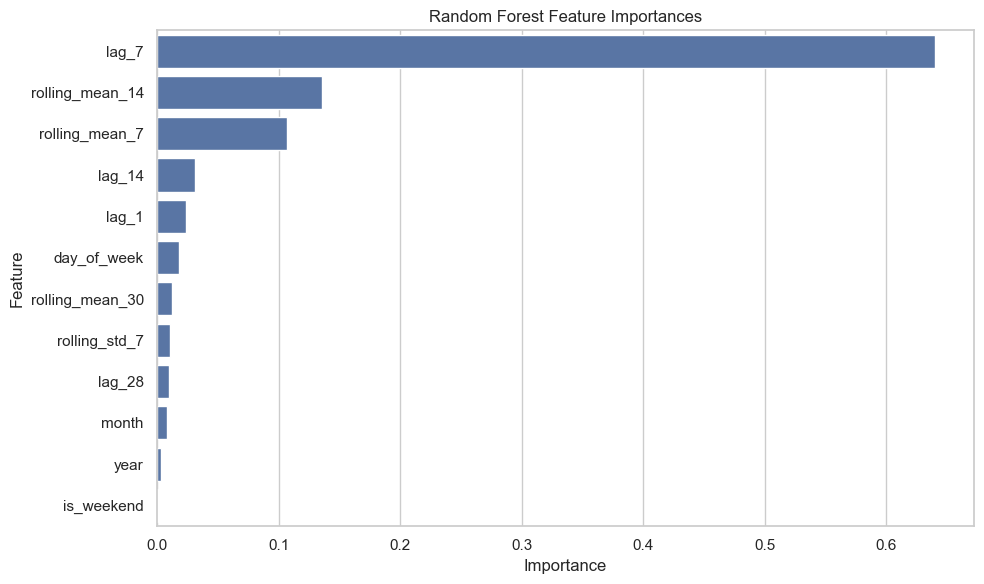

In [24]:
# Get feature importances from the trained random forest model
importances = rf_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

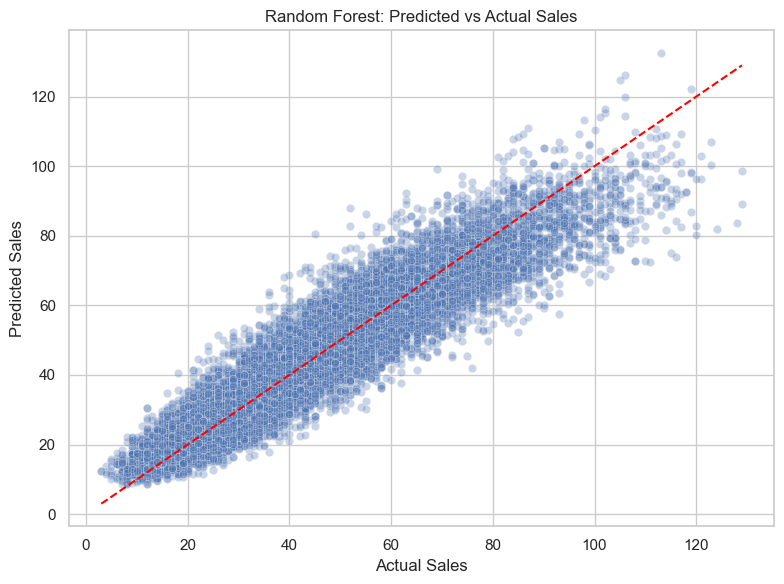

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=rf_preds, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Random Forest: Predicted vs Actual Sales")
plt.tight_layout()
plt.show()

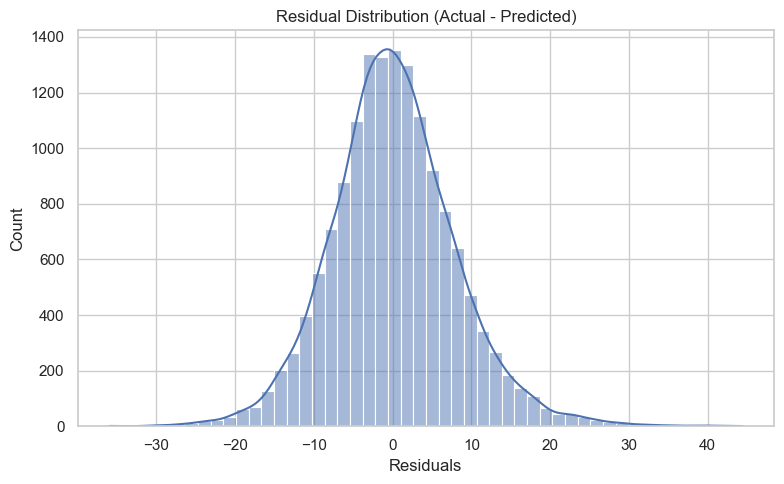

In [30]:
residuals = y_val - rf_preds

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution (Actual - Predicted)")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

In [ ]:
#Hyperparameter tuning for random forest

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Define RMSE as a scoring function (negative because scikit-learn maximizes score)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Parameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Randomized Search
rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=25,
    scoring=rmse_scorer,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
search.fit(X_train, y_train)

# Best model
best_rf = search.best_estimator_

# Evaluate on validation set
best_preds = best_rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, best_preds))

print(f"\nBest Parameters: {search.best_params_}")
print(f"Validation RMSE: {rmse:.4f}")